Ονοματεπώνυμο: Δημήτριος-Γεώργιος-Μιχαήλ Διακάτος    ΑΜ:1115201700288

---


Ονοματεπώνυμο: Εμμανουήλ-Ευδόξιος Αναστασάκης        ΑΜ:1115201700283

In [3]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
import numpy as np
import matplotlib.pyplot as plt
import math
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.metrics import f1_score
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
!pip install --upgrade gensim
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

Requirement already up-to-date: gensim in /usr/local/lib/python3.7/dist-packages (4.0.1)


/usr/local/lib/python3.7/dist-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Import των Fake και non-Fake (true) news.

In [5]:
html_doc=open('/content/drive/MyDrive/Project2/Fake.csv', 'r')
fake=pd.read_csv(html_doc)

html_doc=open('/content/drive/MyDrive/Project2/True.csv', 'r')
true=pd.read_csv(html_doc)

# 1. Προεπεξεργασία/καθάρισμα

Σε αυτό το βήμα κάνουμε την προεπεξεργασία των δεδομένων. Μέσω της dropna αφαιρούμε τις γραμμές που δεν έχουν text, βγάζουμε τα σημεία στίξης με την replace και στο τέλος τα κάνουμε όλα πεζά.

In [6]:
true = true.dropna(subset=['text'])
fake = fake.dropna(subset=['text'])

true['text'] = true['text'].str.replace(',', "")
true['text'] = true['text'].str.replace('“', "")
true['text'] = true['text'].str.replace('”', "")
true['text'] = true['text'].str.replace("’", "")
true['text'] = true['text'].str.replace("(", "")
true['text'] = true['text'].str.replace(")", "")
true['text'] = true['text'].str.replace("-", "")
true['text'] = true['text'].str.replace("?", "")
true['text'] = true['text'].str.replace("'", "")
true['text'] = true['text'].str.replace(".", "")
true['text'] = true['text'].str.lower()

true['title'] = true['title'].str.replace(',', "")
true['title'] = true['title'].str.replace('“', "")
true['title'] = true['title'].str.replace('”', "")
true['title'] = true['title'].str.replace("’", "")
true['title'] = true['title'].str.replace("(", "")
true['title'] = true['title'].str.replace(")", "")
true['title'] = true['title'].str.replace("-", "")
true['title'] = true['title'].str.replace("?", "")
true['title'] = true['title'].str.replace("'", "")
true['title'] = true['title'].str.replace(".", "")
true['title'] = true['title'].str.lower()

fake['text'] = fake['text'].str.replace(',', "")
fake['text'] = fake['text'].str.replace('“', "")
fake['text'] = fake['text'].str.replace('”', "")
fake['text'] = fake['text'].str.replace("’", "")
fake['text'] = fake['text'].str.replace("(", "")
fake['text'] = fake['text'].str.replace(")", "")
fake['text'] = fake['text'].str.replace("-", "")
fake['text'] = fake['text'].str.replace("?", "")
fake['text'] = fake['text'].str.replace("'", "")
fake['text'] = fake['text'].str.replace(".", "")
fake['text'] = fake['text'].str.lower()

fake['title'] = fake['title'].str.replace(',', "")
fake['title'] = fake['title'].str.replace('“', "")
fake['title'] = fake['title'].str.replace('”', "")
fake['title'] = fake['title'].str.replace("’", "")
fake['title'] = fake['title'].str.replace("(", "")
fake['title'] = fake['title'].str.replace(")", "")
fake['title'] = fake['title'].str.replace("-", "")
fake['title'] = fake['title'].str.replace("?", "")
fake['title'] = fake['title'].str.replace("'", "")
fake['title'] = fake['title'].str.replace(".", "")
fake['title'] = fake['title'].str.lower()

# 2. Μελέτη των δεδομένων.

*α. Ο τίτλος καθορίζει αρκετά το περιεχόμενο ενός άρθρου. Προσπαθήστε να
οπτικοποιήστε τους τίτλους των fake και των non-fake news έτσι ώστε να μπορεί
κάποιος να εντοπίσει τα κεντρικά θέματα τα οποία διαπραγματεύονται τα άρθρα. *

Εδώ χρησιμοποιήσαμε την συνάρτηση που έχουμε κάνει στο 3ο εργαστήριο, την wordcount, με την παραλλαγή ότι τώρα βγάζει τα stopwords, για να μετράμε το πόσες φορές εμφανίζεται κάθε λέξη στους τίτλους. Στην συνέχεια, πήραμε τις 15 πιο συχνά εμφανιζόμενες λέξεις απο το DataFrame που μας επιστρέφει η wordcount και σύμφωνα με αυτές κάναμε το wordcloud που είπε η κυρία Κολοβού στο eclass.
 

In [7]:
def wordcount(s):
    wordlist = []
    countlist = []

    stop_words = list(stopwords.words('english')) 

    for word in s:
        if not word in wordlist and word not in stop_words:
            wordlist.append(word)
            countlist.append(1)
        else:
            for j in range(len(wordlist)):
                if wordlist[j] == word and wordlist[j] not in stop_words:
                    countlist[j] = countlist[j] + 1
                    break
                    
    wordlist2 = []
    countlist2 = []
    
    for i in range(0,len(wordlist)):
        if i <= (len(countlist)) and countlist[i] > 1:
            wordlist2.append(wordlist[i])
            countlist2.append(countlist[i])

    return pd.DataFrame({'word':wordlist2, 'count':countlist2})

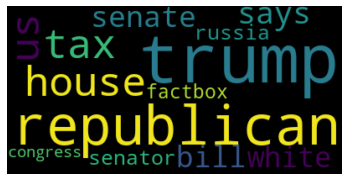

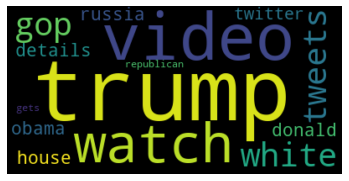

In [8]:
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator


true_title = pd.DataFrame({"title": true['title']})
true_title['title'] = true_title['title'].str.split()
true_title['title'] = true_title['title'].explode(ignore_index=True)
true_title = wordcount(true_title['title'])
true_title = true_title.sort_values(by='count', ascending=False)
true_title = true_title.head(15)

wordcloud = WordCloud().generate(true_title['word'].to_string())

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()


fake_title = pd.DataFrame({"title": fake['title']})
fake_title['title'] = fake_title['title'].str.split()
fake_title['title'] = fake_title['title'].explode(ignore_index=True)
fake_title = wordcount(fake_title['title'])
fake_title = fake_title.sort_values(by='count', ascending=False)
fake_title = fake_title.head(15)

wordcloud = WordCloud().generate(fake_title['word'].to_string())

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

*β. Σχεδιάστε γραφήματα που να δείχνουν το μέσο όρο των χαρακτήρων στα fake και
στα true news αντίστοιχα. Κάντε το ίδιο και για τη στήλη text.*                
Έδω βρίσκουμε την μέση τιμή των χαρακτήρων για τους τίτλους και το text και στο τέλος τα βάζουμε σε ένα καινούργιο dataframe το οποίο το κάνουμε plot.bar. Στο αποτέλεσμα παρατηρούμε ότι οι χαρακτήρες των τίτλων και των text έχουμε μεγάλη διαφορά, αυτό είναι φυσιολογικό γιατί οι τίτλοι πάντα είναι μικρότεροι απο τα κείμενα.

<class 'float'>


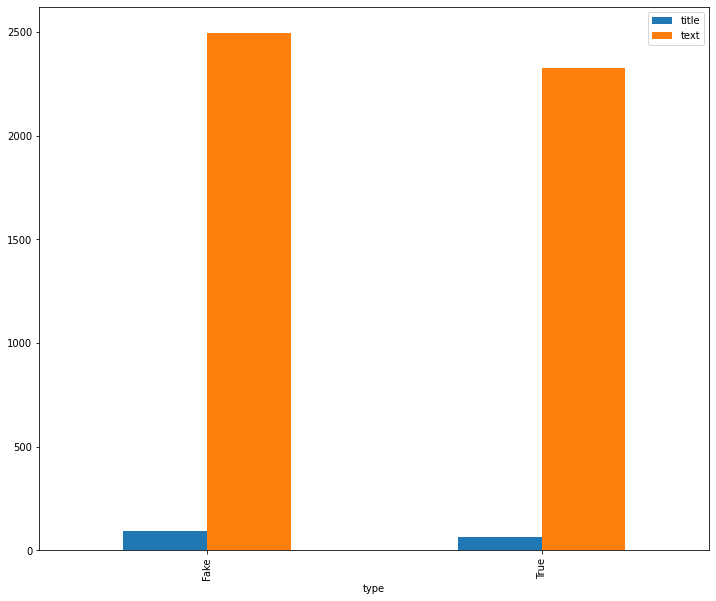

In [9]:
# Find title mean for fake and true
fake_title = pd.DataFrame(fake['title'], columns=['title'])
true_title = pd.DataFrame(true['title'], columns=['title'])

fake_mean_title = fake_title['title'].str.len().mean()
true_mean_title = true_title['title'].str.len().mean()

print(type(fake_mean_title))


# Find text mean for fake and true
fake_text = pd.DataFrame(fake['text'], columns=['text'])
true_text = pd.DataFrame(true['text'], columns=['text'])

fake_mean_text = fake_text['text'].str.len().mean()
true_mean_text = true_text['text'].str.len().mean()

# Make of a united DataFrame
mean = pd.DataFrame(columns=['title', 'text', 'type'])

mean = mean.append({'title':fake_mean_title, 'text':fake_mean_text, 'type': "Fake"}, ignore_index=True)
mean = mean.append({'title':true_mean_title, 'text':true_mean_text, 'type': "True"}, ignore_index=True)

mean = mean.set_index('type')


#Bar settings
mean.plot.bar(figsize=(12,10))
plt.show()

*γ. Σχεδιάστε την κατανομή του αριθμού των λέξεων για τη στήλη title και για τη στήλη text (και για τα δύο αρχεία).*                                           
Εδώ με τις replace, lower, split και explode αυτό που κάνουμε είναι να σπάμε ένα string στις διαφορετικές του λέξεις. Έτσι, με την count καταλήγουμε να έχουμε τον αριθμό των λέξεων για κάθε διαφορετική κατηγορία title και text. Στο τέλος, τα βάζουμε σε ένα dataframe και κάνουμε ενα plot.bar.

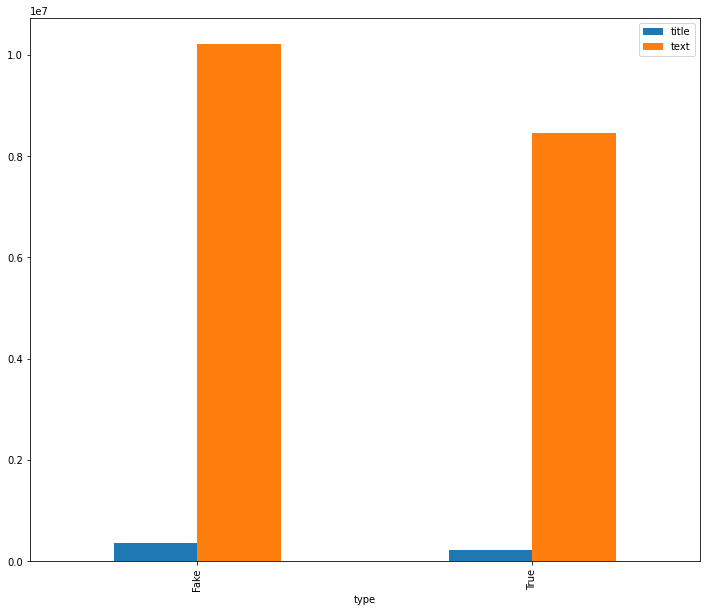

In [10]:
fake_word_title = pd.DataFrame(fake_title, columns=['title'])
fake_word_title['title'] = fake_word_title['title'].str.split(' ')
fake_word_title = fake_word_title.explode('title')


true_word_title = pd.DataFrame(true_title, columns=['title'])
true_word_title['title'] = true_word_title['title'].str.split(' ')
true_word_title = true_word_title.explode('title')


fake_word_text = pd.DataFrame(fake_text, columns=['text'])
fake_word_text['text'] = fake_word_text['text'].str.split(' ')
fake_word_text = fake_word_text.explode('text')


true_word_text = pd.DataFrame(true_text, columns=['text'])
true_word_text['text'] = true_word_text['text'].str.split(' ')
true_word_text = true_word_text.explode('text')



fake_word_title_count = fake_word_title['title'].count()
fake_word_text_count = fake_word_text['text'].count()
true_word_title_count = true_word_title['title'].count()
true_word_text_count = true_word_text['text'].count()

# Make of a united DataFrame
Counts = pd.DataFrame(columns=['title', 'text', 'type'])

Counts = Counts.append({'title':fake_word_title_count, 'text':fake_word_text_count, 'type': "Fake"}, ignore_index=True)
Counts = Counts.append({'title':true_word_title_count, 'text':true_word_text_count, 'type': "True"}, ignore_index=True)

Counts = Counts.set_index('type')

#Bar settings
Counts.plot.bar(figsize=(12,10))
plt.show()

*δ. Επαναλλάβετε το προηγούμενο ερώτημα αφαιρώντας τα stopwords.* Εδώ, κάνουμε τα ίδια με πρίν με την διαφορά ότι καλούμε την συνάρτηση RemoveStopWords και έτσι αφαιρούμε τα stopwords.

In [11]:
def RemoveStopWords(text):
  stop_words = set(stopwords.words('english')) 
    
  word_tokens = word_tokenize(text) 
    
  filtered_sentence = [w for w in word_tokens if not w in stop_words] 
    
  filtered_sentence = [] 
    
  for w in word_tokens: 
      if w not in stop_words: 
          filtered_sentence.append(w) 

  return filtered_sentence

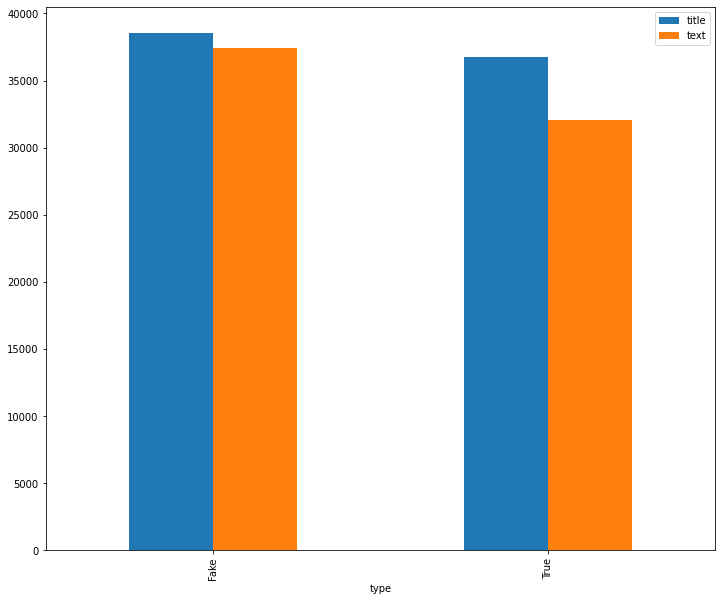

In [12]:
fake_word_title = pd.DataFrame(fake['title'], columns=['title'])
fake_word_title['title'] = fake_word_title['title'].str.replace(',', ' ')
fake_title_SW = RemoveStopWords(fake_word_title['title'].to_string())


true_word_title = pd.DataFrame(true['title'], columns=['title'])
true_word_title['title'] = true_word_title['title'].str.replace(',', ' ')
true_title_SW = RemoveStopWords(true_word_title['title'].to_string())


fake_word_text = pd.DataFrame(fake['text'], columns=['text'])
fake_word_text['text'] = fake_word_text['text'].str.replace(',', ' ')
fake_text_SW = RemoveStopWords(fake_word_text['text'].to_string())

true_word_text = pd.DataFrame(true['text'], columns=['text'])
true_word_text['text'] = true_word_text['text'].str.replace(',', ' ')
true_text_SW = RemoveStopWords(true_word_text['text'].to_string())


fake_word_title_count = len(set(fake_title_SW))
fake_word_text_count = len(set(fake_text_SW))
true_word_title_count = len(set(true_title_SW))
true_word_text_count = len(set(true_text_SW))

# Make of a united DataFrame
Counts = pd.DataFrame(columns=['title', 'text', 'type'])

Counts = Counts.append({'title':fake_word_title_count, 'text':fake_word_text_count, 'type': "Fake"}, ignore_index=True)
Counts = Counts.append({'title':true_word_title_count, 'text':true_word_text_count, 'type': "True"}, ignore_index=True)

Counts = Counts.set_index('type')

#Bar settings
Counts.plot.bar(figsize=(12,10))
plt.show()

*ε. Ποιά είναι τα πιο συχνά (πχ 10 ή 20) bigrams στους τίτλους και ποιά στο κυρίως άρθρο;* Εδω κάνουμε δύο CountVectorizer ένα για τα title και ένα για τα text και στην συνέχεια περνουμέ τον αριθμό των φορών που βρίσκεται στο καθένα dataframe. Και στο τέλος κάνουμε δύο plot ώστε να βγουν τα αποτελέσματα που βρήκαμε σε γραφήματα.

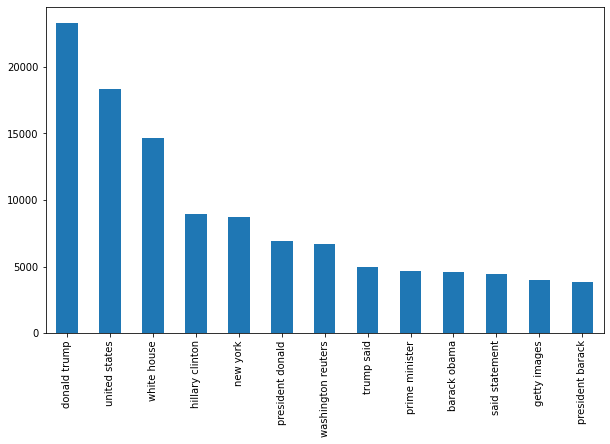

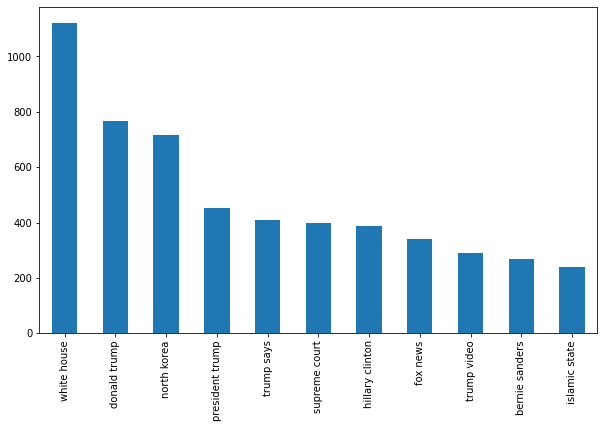

In [13]:
United_title = pd.concat([fake_word_title, true_word_title], ignore_index=True)
United_text = pd.concat([fake_word_text, true_word_text], ignore_index=True)

corpus = United_title['title']

vectorizer = CountVectorizer(strip_accents='unicode', min_df=0.005, stop_words='english', binary=True, ngram_range=(2, 2), lowercase=True)
X = vectorizer.fit_transform(corpus)
dense=X.todense()
denselist=dense.tolist()
vocabularybow=vectorizer.get_feature_names()
BoW_title = pd.DataFrame(denselist, columns=vocabularybow, dtype=int)
BoW_title = BoW_title.merge(United_title, right_index=True, left_index=True)
BoW_title = BoW_title.drop(columns=['title'])
Sum_title = BoW_title.sum(axis=0)
Sum_title = Sum_title.sort_values(ascending=False)

corpus = United_text['text']

vectorizer = CountVectorizer(strip_accents='unicode', min_df=0.07, stop_words='english', ngram_range=(2, 2), lowercase=True)
X = vectorizer.fit_transform(corpus)
dense=X.todense()
denselist=dense.tolist()
vocabularybow=vectorizer.get_feature_names()

BoW_text = pd.DataFrame(denselist, columns=vocabularybow, dtype=int)
BoW_text = BoW_text.merge(United_text, right_index=True, left_index=True)
BoW_text = BoW_text.drop(columns=['text'])
Sum_text = BoW_text.sum(axis=0)
Sum_text = Sum_text.sort_values(ascending=False)

Sum_text.plot.bar(figsize=(10,6))
plt.show()

Sum_title.plot.bar(figsize=(10,6))
plt.show()

# 3. Δημιουργία συνόλου εκμάθησης και δοκιμής

Εδώ φτιάχνουμαι την στήλη label για κάθε dataframe και στην συνέχεια φτιάχνουμαι το σύλονο εκμάθησης και ελέγχου.

In [32]:
fake['label'] = 0
true['label'] = 1

train = pd.concat([fake[:1000], true[:1000]], ignore_index=True) # 2000
test = pd.concat([fake[1001:2001], true[1001:2001]], ignore_index=True) # 2448

train.to_csv('/content/drive/MyDrive/Project2/train.csv', index=False)
test.to_csv('/content/drive/MyDrive/Project2/test.csv', index=False)



# 2. Υλοποίηση Κατηγοριοποίησης (Classification)

*1. Στον αντίστοιχο πίνακα document-words που θα προκύψει από την BoW αναπαράσταση των κειμένων τόσο σε απλά counts, όσο και ξεχωριστά στον tf-idf μετασχηματισμό των counts.*

Στην ουσία εδώ ακολουθούμε την λογική της πρώτης εργασίας.  Δηλαδή κάνουμε CountVectorizer ή TfidfVectorizer ανάλογα το τι θέλουμε και στην συνέχεια τα φορτώνουμαι σε ένα dataframe. 

In [15]:
def toBoW(df):
  corpus = df

  vectorizer = CountVectorizer(strip_accents='unicode', ngram_range=(1, 1), stop_words='english', lowercase=True)
  X = vectorizer.fit_transform(corpus)
  dense=X.todense()

  denselist=dense.tolist()
  vocabularybow=vectorizer.get_feature_names()
  
  BoW = pd.DataFrame(denselist, columns=vocabularybow, dtype=int)
  BoW = BoW.merge(df, right_index=True, left_index=True)
  return BoW


def totfidf(df):
  corpus = df

  tfidf = TfidfVectorizer(strip_accents='unicode', ngram_range=(1, 1), stop_words='english', lowercase=True)
  vect = tfidf.fit_transform(corpus)

  dense=vect.toarray()
  vocabularytf = tfidf.get_feature_names() # Get all the words from the corpus

  tf = pd.DataFrame(dense, columns=vocabularytf)
  tf = tf.merge(df, right_index=True, left_index=True)
  return tf

Κάνουμε ένα united dataframe που περιέχει το train και το test data και στην συνέχεια εκτελούμε τις τέσσερεις κατηγοριοποιήσεις Logistic Regression, Naive Bayes, SVM και Random Forests για το Bow και το Tf-idf και πέρνουμε το accuracy_score και το f1_score για το καθένα. Παρατηρούμε ότι accuracy_score και το f1_score βγαίνουν ίδια, ο λόγος είναι ότι έχουμε δύο κατηγορίες(fake & true). Επίσης δοκιμάσαμε με macro και weighted και έβγαζε τα ίδια αποτελέσματα. 

> ● Logistic Regression

In [16]:
united = pd.concat([train, test], ignore_index=True)

#-------------BoW-------------#

unitedBow = toBoW(united['text'])

# Arrays with labels for train and test.
trainlabelBoW = np.asarray(train['label'])
testlabelBoW = np.asarray(test['label'])

# BoW for text.
traindataBoW = np.asarray(unitedBow[:2000].drop('text_y', 1))
testdataBoW = np.asarray(unitedBow[2000:].drop('text_y', 1))

# Model for BoW.
model = LogisticRegression()
model.fit(traindataBoW, trainlabelBoW)
y_pred = model.predict(testdataBoW)
print(f"Scikit learn logistic regression accuracy for BoW is {accuracy_score(testlabelBoW, y_pred)*100:.2f}")
print(f"Scikit learn logistic regression f1 score for BoW is {f1_score(testlabelBoW, y_pred, average='micro')*100:.2f}")

Scikit learn logistic regression accuracy for BoW is 99.30
Scikit learn logistic regression f1 score for BoW is 99.30


In [17]:
#-------------tf/idf-------------#
unitedtf = totfidf(united['text'])

# Arrays with labels for train and test.
trainlabeltf = np.asarray(train['label'])
testlabeltf = np.asarray(test['label'])

# tf/idf for text.
traindatatf = np.asarray(unitedtf[:2000].drop('text_y', 1))
testdatatf = np.asarray(unitedtf[2000:].drop('text_y', 1))

# Model for tf/idf.
model = LogisticRegression()
model.fit(traindatatf, trainlabeltf)
y_pred = model.predict(testdatatf)
print(f"Scikit learn logistic regression accuracy for tf-idf is {accuracy_score(testlabeltf, y_pred)*100:.2f}")
print(f"Scikit learn logistic regression f1 score for tf-idf is {f1_score(testlabeltf, y_pred, average='micro')*100:.2f}")

Scikit learn logistic regression accuracy for tf-idf is 97.50
Scikit learn logistic regression f1 score for tf-idf is 97.50




> ● Naive Bayes



In [18]:
model = GaussianNB()
model.fit(traindataBoW, trainlabelBoW)
y_pred = model.predict(testdataBoW)

print(f"Scikit learn logistic regression accuracy for BoW is {accuracy_score(testlabelBoW, y_pred)*100:.2f}")
print(f"Scikit learn logistic regression f1 score for BoW is {f1_score(testlabelBoW, y_pred, average='micro')*100:.2f}")

Scikit learn logistic regression accuracy for BoW is 87.95
Scikit learn logistic regression f1 score for BoW is 87.95


In [19]:
model = GaussianNB()
model.fit(traindatatf, trainlabeltf)
y_pred = model.predict(testdatatf)
print(f"Scikit learn logistic regression accuracy for tf-idf is {accuracy_score(testlabeltf, y_pred)*100:.2f}")
print(f"Scikit learn logistic regression f1 score for tf-idf is {f1_score(testlabeltf, y_pred, average='micro')*100:.2f}")

Scikit learn logistic regression accuracy for tf-idf is 85.50
Scikit learn logistic regression f1 score for tf-idf is 85.50




> ● Support Vector Machines (SVM, να πειραματιστείτε με τις παραμέτρους kernel
(rbf, linear), c και gamma. H επιλογή των παραμέτρων μπορεί να γίνει και με
GridSearchCV)



In [20]:
model = SVC(gamma='auto', kernel='linear', C=2)
model.fit(traindataBoW, trainlabelBoW)
y_pred = model.predict(testdataBoW)

print(f"Scikit learn logistic regression accuracy for BoW is {accuracy_score(testlabelBoW, y_pred)*100:.2f}")
print(f"Scikit learn logistic regression f1 score for BoW is {f1_score(testlabelBoW, y_pred, average='micro')*100:.2f}")

Scikit learn logistic regression accuracy for BoW is 99.40
Scikit learn logistic regression f1 score for BoW is 99.40


In [21]:
model = SVC(gamma='auto', kernel='linear', C=2)
model.fit(traindatatf, trainlabeltf)
y_pred = model.predict(testdatatf)
print(f"Scikit learn logistic regression accuracy for tf-idf is {accuracy_score(testlabeltf, y_pred)*100:.2f}")
print(f"Scikit learn logistic regression f1 score for tf-idf is {f1_score(testlabeltf, y_pred, average='micro')*100:.2f}")


Scikit learn logistic regression accuracy for tf-idf is 98.90
Scikit learn logistic regression f1 score for tf-idf is 98.90


> ● Random Forests

In [22]:
model = RandomForestClassifier(max_depth=2, random_state=0)
model.fit(traindataBoW, trainlabelBoW)
y_pred = model.predict(testdataBoW)

print(f"Scikit learn logistic regression accuracy for BoW is {accuracy_score(testlabelBoW, y_pred)*100:.2f}")
print(f"Scikit learn logistic regression f1 score for BoW is {f1_score(testlabelBoW, y_pred, average='micro')*100:.2f}")

Scikit learn logistic regression accuracy for BoW is 99.35
Scikit learn logistic regression f1 score for BoW is 99.35


In [23]:
model = RandomForestClassifier(max_depth=2, random_state=0)
model.fit(traindatatf, trainlabeltf)
y_pred = model.predict(testdatatf)
print(f"Scikit learn logistic regression accuracy for tf-idf is {accuracy_score(testlabeltf, y_pred)*100:.2f}")
print(f"Scikit learn logistic regression f1 score for tf-idf is {f1_score(testlabeltf, y_pred, average='micro')*100:.2f}")

Scikit learn logistic regression accuracy for tf-idf is 99.10
Scikit learn logistic regression f1 score for tf-idf is 99.10


*2.Στον αντίστοιχο πίνακα document-vectors που θα προκύψει από το word2v (μορείτε να δοκιμάσετε και pre-trained embeddings, είτε από το word2vec, είτε glove ή το fast-text)*

Την συνάρτηση αυτή την πήραμε από το φροντιστήριο. Κάναμε κάποιες αλλαγές διότι το vocab.keys δεν δουλεύει και το αντικαταστήσαμε με το wv.index_to_key. Επίσης έβγαζε πρόβλημα με τα $ για αυτό τα βγάλαμε. Μετά για το μόντελ κάναμε ότι κάνατε και στο φροντιστήριο. 

In [24]:
def display_pca_scatterplot(model, words=None, sample=0):
    new_words = list()
    if words == None:
      if sample > 0:
          new_words = np.random.choice(list(model.wv.index_to_key), sample)
      else:
          for word in model.wv.index_to_key:
            if word != '$$':
              new_words.append(word)

    word_vectors = np.array([model.wv[w] for w in new_words])
    print(word_vectors.shape)

    twodim = PCA().fit_transform(word_vectors)[:,:2]

    plt.figure(figsize=(15,15))
    plt.scatter(twodim[:,0], twodim[:,1], edgecolors='k', c='r')
    for word, (x,y) in zip(new_words, twodim):
        plt.text(x+0.1, y+0.1, word)
    plt.show()

(17854, 50)


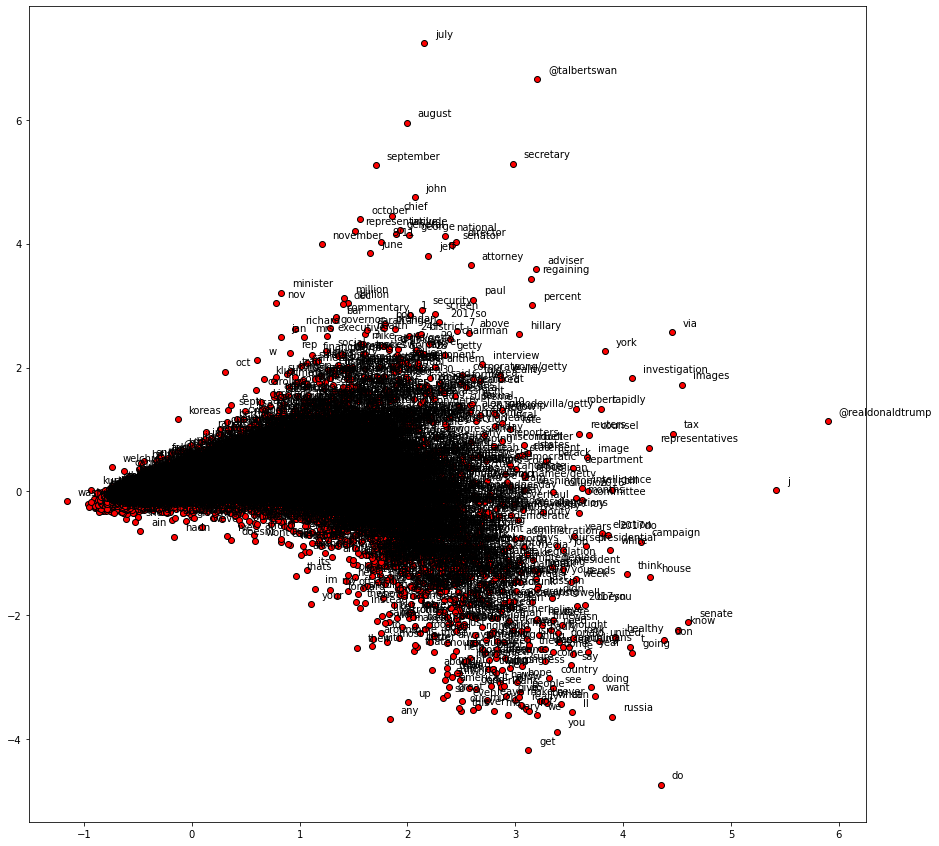

In [25]:
tokens=train['text'].apply(lambda x: x.split())


w2vmodel = Word2Vec(tokens, vector_size=50, seed=32, negative=5, sg=0, min_count=2, window=2, workers=4)

w2vmodel.build_vocab(tokens)  # prepare the model vocabulary

w2vmodel.train(tokens, total_examples=w2vmodel.corpus_count, epochs=5); # train the model

display_pca_scatterplot(w2vmodel)

Εδώ δίνουμε στην συνάρητηση μια λίστα από λέξεις και με την χρήση του word2vec βρίσκουμε το μέσο(mean) όλων των λέξεων και στην συνέχεια χρησιμοποιούμε τις αντίστοιχες συναρτήσεις τις κατηγοροποίησεις.  

In [26]:
def document_vector(doc):
    """Create document vectors by averaging word vectors. Remove out-of-vocabulary words."""
    doc = [word for word in doc if word in w2vmodel.wv.index_to_key]
    return np.mean(w2vmodel.wv[doc], axis=0)

In [27]:
x=[]
for sentence in train['text'] :
  sentence = sentence.split()
  vec = document_vector(sentence)
  x.append(vec)

x_test=[]
for sentence in test['text'] :
  sentence = sentence.split()
  vec = document_vector(sentence)
  x_test.append(vec)

> ● Logistic Regression


In [28]:
model = LogisticRegression()
model.fit(x, train['label'])
y_pred = model.predict(x_test)

print(f"Scikit learn logistic regression accuracy for BoW is {accuracy_score(test['label'], y_pred)*100:.2f}")
print(f"Scikit learn logistic regression f1 score for BoW is {f1_score(test['label'], y_pred, average='micro')*100:.2f}")

Scikit learn logistic regression accuracy for BoW is 96.45
Scikit learn logistic regression f1 score for BoW is 96.45


> ● Naive Bayes

In [29]:
model = GaussianNB()
model.fit(x, train['label'])
y_pred = model.predict(x_test)

print(f"Scikit learn logistic regression accuracy for BoW is {accuracy_score(test['label'], y_pred)*100:.2f}")
print(f"Scikit learn logistic regression f1 score for BoW is {f1_score(test['label'], y_pred, average='micro')*100:.2f}")

Scikit learn logistic regression accuracy for BoW is 92.75
Scikit learn logistic regression f1 score for BoW is 92.75


> ● Support Vector Machines (SVM, να πειραματιστείτε με τις παραμέτρους kernel
(rbf, linear), c και gamma. H επιλογή των παραμέτρων μπορεί να γίνει και με
GridSearchCV)

In [30]:
model = SVC(gamma='auto', kernel='linear', C=2)
model.fit(x, train['label'])
y_pred = model.predict(x_test)

print(f"Scikit learn logistic regression accuracy for BoW is {accuracy_score(test['label'], y_pred)*100:.2f}")
print(f"Scikit learn logistic regression f1 score for BoW is {f1_score(test['label'], y_pred, average='micro')*100:.2f}")

Scikit learn logistic regression accuracy for BoW is 97.85
Scikit learn logistic regression f1 score for BoW is 97.85


> ● Random Forests

In [31]:
model = RandomForestClassifier(max_depth=2, random_state=0)
model.fit(x, train['label'])
y_pred = model.predict(x_test)

print(f"Scikit learn logistic regression accuracy for BoW is {accuracy_score(test['label'], y_pred)*100:.2f}")
print(f"Scikit learn logistic regression f1 score for BoW is {f1_score(test['label'], y_pred, average='micro')*100:.2f}")

Scikit learn logistic regression accuracy for BoW is 92.15
Scikit learn logistic regression f1 score for BoW is 92.15
